### Graph dependecies

In [1]:
import graphviz

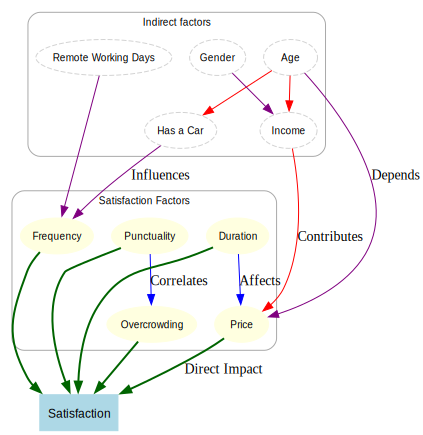

In [2]:
from graphviz import Digraph

# Create a Digraph object
dot = Digraph('Passenger Satisfaction')
dot.attr(rankdir='TB', size='7,9')  # Vertical layout, larger canvas for hierarchy

# Define node styles
dot.attr('node', shape='box', style='filled', color='lightblue', fontname='Helvetica', fontsize='12')
dot.node('S', 'Satisfaction')

# Factors directly affecting satisfaction
dot.attr('node', shape='ellipse', style='filled', color='lightyellow', fontname='Helvetica', fontsize='10')
dot.node('P', 'Price')
dot.node('U', 'Punctuality')
dot.node('D', 'Duration')
dot.node('F', 'Frequency')
dot.node('O', 'Overcrowding')

# Indirect factors
dot.attr('node', shape='ellipse', style='dashed', color='lightgray', fontname='Helvetica', fontsize='10')
dot.node('A', 'Age')
dot.node('G', 'Gender')
dot.node('I', 'Income')
dot.node('R', 'Remote Working Days')
dot.node('C', 'Has a Car')

# Organize clusters
with dot.subgraph(name='cluster_independent') as c:
    c.attr(label='Indirect factors', style='rounded', color='darkgray', fontname='Helvetica', fontsize='10')
    c.node('A')
    c.node('G')
    c.node('I')
    c.node('R')
    c.node('C')

with dot.subgraph(name='cluster_factors') as c:
    c.attr(label='Satisfaction Factors', style='rounded', color='darkgray', fontname='Helvetica', fontsize='10')
    c.node('P')
    c.node('U')
    c.node('D')
    c.node('F')
    c.node('O')

# Add edges for satisfaction factors
dot.edge('P', 'S', color='darkgreen', penwidth='2', label='Direct Impact')
dot.edge('U', 'S', color='darkgreen', penwidth='2')
dot.edge('D', 'S', color='darkgreen', penwidth='2')
dot.edge('F', 'S', color='darkgreen', penwidth='2')
dot.edge('O', 'S', color='darkgreen', penwidth='2')

# Relationships among features
dot.edge('D', 'P', color='blue', label='Affects')
dot.edge('U', 'O', color='blue', label='Correlates')

dot.edge('A', 'P', color='purple', label='Depends')
dot.edge('C', 'F', color='purple', label='Influences')
dot.edge('G', 'I', color='purple')
dot.edge('R', 'F', color='purple')

dot.edge('I', 'P', color='red', label='Contributes')
dot.edge('A', 'I', color='red')
dot.edge('A', 'C', color='red')

# Render the graph
dot

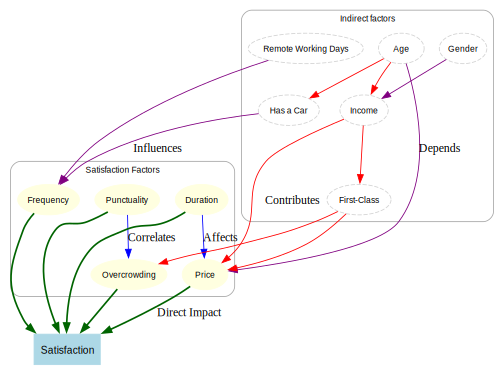

In [3]:
from graphviz import Digraph

# Create a Digraph object
dot = Digraph('Passenger Satisfaction')
dot.attr(rankdir='TB', size='7,9')  # Vertical layout, larger canvas for hierarchy

# Define node styles
dot.attr('node', shape='box', style='filled', color='lightblue', fontname='Helvetica', fontsize='12')
dot.node('S', 'Satisfaction')

# Factors directly affecting satisfaction
dot.attr('node', shape='ellipse', style='filled', color='lightyellow', fontname='Helvetica', fontsize='10')
dot.node('P', 'Price')
dot.node('U', 'Punctuality')
dot.node('D', 'Duration')
dot.node('F', 'Frequency')
dot.node('O', 'Overcrowding')

# Indirect factors
dot.attr('node', shape='ellipse', style='dashed', color='lightgray', fontname='Helvetica', fontsize='10')
dot.node('A', 'Age')
dot.node('G', 'Gender')
dot.node('I', 'Income')
dot.node('R', 'Remote Working Days')
dot.node('C', 'Has a Car')
dot.node('1', 'First-Class')

# Organize clusters
with dot.subgraph(name='cluster_independent') as c:
    c.attr(label='Indirect factors', style='rounded', color='darkgray', fontname='Helvetica', fontsize='10')
    c.node('A')
    c.node('G')
    c.node('I')
    c.node('R')
    c.node('C')
    c.node('1')

with dot.subgraph(name='cluster_factors') as c:
    c.attr(label='Satisfaction Factors', style='rounded', color='darkgray', fontname='Helvetica', fontsize='10')
    c.node('P')
    c.node('U')
    c.node('D')
    c.node('F')
    c.node('O')

# Add edges for satisfaction factors
dot.edge('P', 'S', color='darkgreen', penwidth='2', label='Direct Impact')
dot.edge('U', 'S', color='darkgreen', penwidth='2')
dot.edge('D', 'S', color='darkgreen', penwidth='2')
dot.edge('F', 'S', color='darkgreen', penwidth='2')
dot.edge('O', 'S', color='darkgreen', penwidth='2')

# Relationships among features
dot.edge('D', 'P', color='blue', label='Affects')
dot.edge('U', 'O', color='blue', label='Correlates')

dot.edge('A', 'P', color='purple', label='Depends')
dot.edge('C', 'F', color='purple', label='Influences')
dot.edge('G', 'I', color='purple')
dot.edge('R', 'F', color='purple')

dot.edge('I', 'P', color='red', label='Contributes')
dot.edge('A', 'I', color='red')
dot.edge('I', '1', color='red')
dot.edge('A', 'C', color='red')
dot.edge('1', 'O', color='red')
dot.edge('1', 'P', color='red')

# Render the graph
dot.render(format='png')
dot

### Data generation

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GenerativeModel import *

In [5]:
#seed
np.random.seed(1)

In [6]:
#generation of synthethic data
def generate_data(size):
    sim_complex = ComplexDependentSatisfaction(size)
    sim_impact = ImpactOnOvercrowding(size)
    return sim_complex, sim_impact

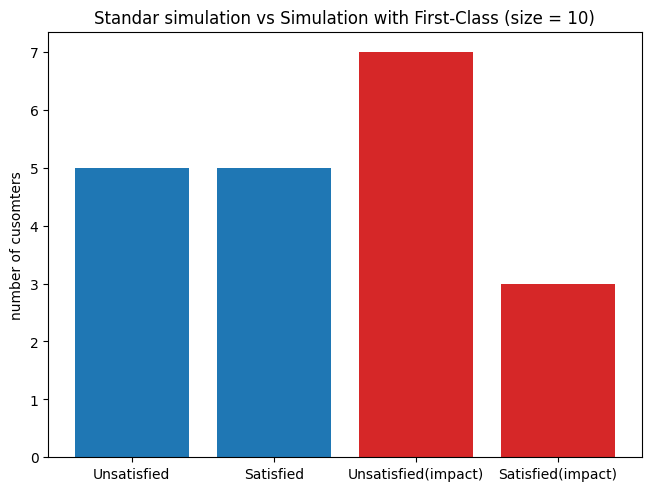

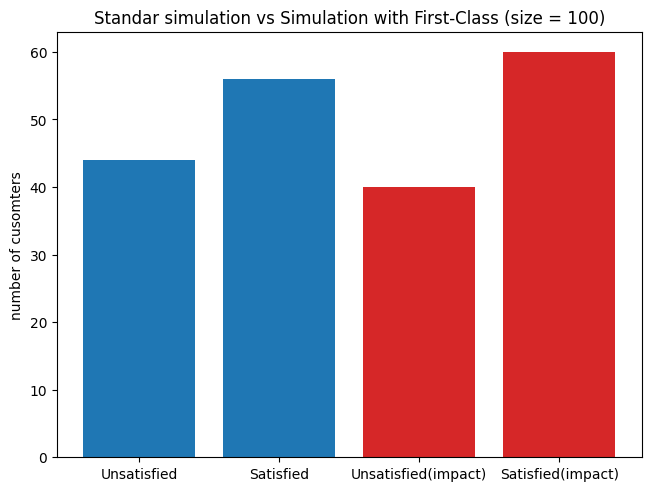

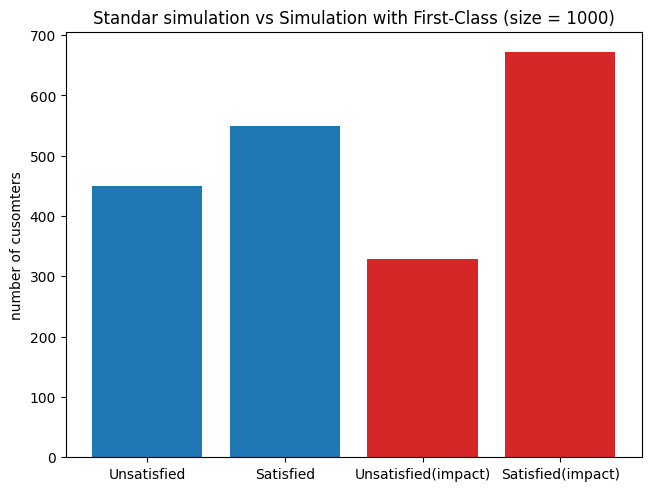

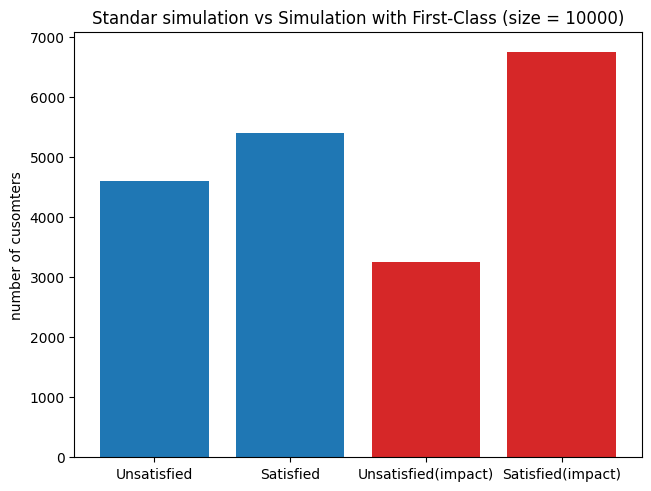

In [7]:
for el in [10, 100, 1000, 10000]:
    sim_complex, sim_impact = generate_data(el)
    data_complex = sim_complex.df
    data_impact = sim_impact.df
    
    satisf_complex = data_complex['Satisfaction'].value_counts()
    satisf_impact = data_impact['Satisfaction'].value_counts()
    
    fig, ax = plt.subplots(layout="constrained")
    bar_colors = ['tab:blue', 'tab:blue', 'tab:red', 'tab:red']
    ax.bar(["Unsatisfied", "Satisfied", "Unsatisfied(impact)", "Satisfied(impact)"], 
           [satisf_complex['0'], satisf_complex['1'],
           satisf_impact['0'], satisf_impact['1']], color=bar_colors)
    ax.set_ylabel("number of cusomters")
    ax.set_title(f"Standar simulation vs Simulation with First-Class (size = {el})")
    plt.show()


### Simple Pipeline

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [9]:
numeric_features = [ "Age", "Income", "Remote Working Days",
                    "Price", "Punctuality", "Duration", "Frequency",
                    "Overcrowding"]

# numeric_features_impact = [ "Age", "Income", "Remote Working Days", "First-Class",
#                     "Price", "Punctuality", "Duration", "Frequency",
#                     "Overcrowding"]

numeric_transformer = Pipeline(
    steps=[("scaler", MinMaxScaler())]
)

categorical_features_complex = ["Has Car", "Gender"]
categorical_features_impact = ["Has Car", "Gender", "First-Class"]

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder())
    ]
)

preprocessor_complex = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features_complex),
    ]
)

preprocessor_impact = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features_impact),
    ]
)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

In [11]:
def simple_pipeline(simulator, data_size, preprocessor):
    np.random.seed(1)
    gen = simulator(data_size)
    data = gen.df
    
    X = data.copy().drop(['Satisfaction'], axis=1)
    y = data['Satisfaction']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    def my_pipeline(model, preprocessor):
        clf = Pipeline(
        steps=[("preprocessor", preprocessor),
               ("classifier", model)]
        )
        clf.fit(X_train, y_train)
        return clf.score(X_test, y_test)

    score_random_forest = my_pipeline(RandomForestClassifier(random_state=42), preprocessor)
    score_logistic = my_pipeline(LogisticRegression(random_state=42), preprocessor)
    score_perceptron = my_pipeline(Perceptron(random_state=42), preprocessor)
    score_knn = my_pipeline(KNeighborsClassifier(), preprocessor)
    
    print(f"Simulator = {gen}, Size of data = {data_size}")
    print(f"Accuracy score for Random Forest Classifier: {score_random_forest:.4f}")
    print(f"Accuracy score for Logistic Regression: {score_logistic:.4f}")
    print(f"Accuracy score for Single Layer Perceptron: {score_perceptron:.4f}")
    print(f"Accuracy score for KNeighborsClassifier: {score_knn:.4f}")

In [12]:
for el in [10, 100, 1000, 10000, 30000, 50000]:
    simple_pipeline(ComplexDependentSatisfaction, el, preprocessor_complex)
    print()
    simple_pipeline(ImpactOnOvercrowding, el, preprocessor_impact)
    print("---------------------------------")
    

Simulator = ComplexDependentSatisfaction, Size of data = 10
Accuracy score for Random Forest Classifier: 0.2500
Accuracy score for Logistic Regression: 0.2500
Accuracy score for Single Layer Perceptron: 0.2500
Accuracy score for KNeighborsClassifier: 0.2500

Simulator = ImpactOnOvercrowding, Size of data = 10
Accuracy score for Random Forest Classifier: 0.5000
Accuracy score for Logistic Regression: 0.7500
Accuracy score for Single Layer Perceptron: 0.7500
Accuracy score for KNeighborsClassifier: 0.7500
---------------------------------
Simulator = ComplexDependentSatisfaction, Size of data = 100
Accuracy score for Random Forest Classifier: 0.7576
Accuracy score for Logistic Regression: 0.7273
Accuracy score for Single Layer Perceptron: 0.7576
Accuracy score for KNeighborsClassifier: 0.7576

Simulator = ImpactOnOvercrowding, Size of data = 100
Accuracy score for Random Forest Classifier: 0.8485
Accuracy score for Logistic Regression: 0.8485
Accuracy score for Single Layer Perceptron: 0

### Feature selection

In [13]:
# RFE
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

def RFE_model(data):
    # Define the model using linear regression
    model = LogisticRegression(random_state=42)

    # Define RFE with the model and specify the number of features to select
    rfe = RFE(model, n_features_to_select=5)

    # Separate features and target variable
    X = data.drop(columns=['Satisfaction'])
    y = data['Satisfaction']

    scale = MinMaxScaler()
    X_minmax = scale.fit_transform(X)
    # Fit RFE to the data
    rfe.fit(X_minmax, y)

    # Get the ranking of features
    feature_ranking = pd.DataFrame({
        'feature': X.columns,
        'rank': rfe.ranking_
    }).sort_values(by='rank')

    return feature_ranking

In [14]:
from sklearn.ensemble import RandomForestClassifier

sizes = [10, 100, 1000, 10000, 30000, 50000]
length = len(sizes)
corr_results_complex = list()
corr_results_impact = list()
RFE_results_complex = list()
RFE_results_impact = list()
random_forest_results_complex = list()
random_forest_results_impact = list()
for i in range(length):
    data_size = sizes[i]
    sim_complex, sim_impact = generate_data(data_size)
    
    data_complex = sim_complex.df
    data_complex['Gender'] = data_complex['Gender'].map({'M': 1, 'F': 0})
    data_complex['Has Car'] = data_complex['Has Car'].map({'yes': 1, 'no': 0})
    
    data_impact = sim_impact.df
    data_impact['Gender'] = data_impact['Gender'].map({'M': 1, 'F': 0})
    data_impact['Has Car'] = data_impact['Has Car'].map({'yes': 1, 'no': 0})
    
    # filer method
    correlations_complex = data_complex.corr()['Satisfaction'].abs().sort_values(ascending=False)
    corr_results_complex.append(correlations_complex)
    
    correlations_impact = data_impact.corr()['Satisfaction'].abs().sort_values(ascending=False)
    corr_results_impact.append(correlations_impact)
    
    # RFE
    RFE_complex = RFE_model(data_complex)
    RFE_impact = RFE_model(data_impact)
    RFE_results_complex.append(RFE_complex) # RFE with top 5 features selected
    RFE_results_impact.append(RFE_impact)
    # Random Forest
    X_complex = data_complex.drop(columns=['Satisfaction'])
    y_complex = data_complex['Satisfaction']

    X_impact = data_impact.drop(columns=['Satisfaction'])
    y_impact = data_impact['Satisfaction']
    
    scale = MinMaxScaler()
    X_complex_minmax = scale.fit_transform(X_complex)
    X_impact_minmax = scale.fit_transform(X_impact)
    
    # Train a Random Forest model
    model_complex = RandomForestClassifier(random_state=42)
    model_impact = RandomForestClassifier(random_state=42)
    model_complex.fit(X_complex_minmax, y_complex)
    model_impact.fit(X_impact_minmax, y_impact)
    

    # Get feature importances
    importances_complex = pd.DataFrame({
        'feature': X_complex.columns,
        'importance': model_complex.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    importances_impact = pd.DataFrame({
        'feature': X_impact.columns,
        'importance': model_impact.feature_importances_
    }).sort_values(by='importance', ascending=False)

    random_forest_results_complex.append(importances_complex)
    random_forest_results_impact.append(importances_impact)
    
    print("+++++++++++++++++++++++++++++++")
    print("Size of the simulations: ", data_size)
    print("+++++++++++++++++++++++++++++++\n")
    print("-------- Filter method --------")
    print(f"Simulation: {sim_complex}")
    print('correlation:',correlations_complex, '\n')
    print(f"Simulation: {sim_impact}")
    print('correlation:',correlations_impact)
    print()
    # RFE
    print("------------- RFE -------------")
    print(f"Simulation: {sim_complex}")
    print(RFE_complex)
    print()
    print(f"Simulation: {sim_impact}")
    print(RFE_impact)
    print()
    print("-------- Random Forest --------")
    print(f"Simulation: {sim_complex}")
    print(importances_complex)
    print()
    print(f"Simulation: {sim_impact}")
    print(importances_impact)
    print()
    

+++++++++++++++++++++++++++++++
Size of the simulations:  10
+++++++++++++++++++++++++++++++

-------- Filter method --------
Simulation: ComplexDependentSatisfaction
correlation: Satisfaction           1.000000
Overcrowding           0.801784
Punctuality            0.534522
Duration               0.449089
Frequency              0.411173
Income                 0.383649
Price                  0.352738
Has Car                0.218218
Age                    0.206078
Remote Working Days    0.138527
Gender                 0.089087
Name: Satisfaction, dtype: float64 

Simulation: ImpactOnOvercrowding
correlation: Satisfaction           1.000000
Overcrowding           0.829156
First-Class            0.801784
Punctuality            0.365600
Remote Working Days    0.342327
Income                 0.327691
Frequency              0.240772
Has Car                0.166667
Price                  0.159448
Age                    0.117851
Gender                 0.102062
Duration               0.063758
N

In [15]:
# Data Generation
sim_complex, sim_impact = generate_data(10000)

data_complex = sim_complex.df
data_complex['Gender'] = data_complex['Gender'].map({'M': 1, 'F': 0})
data_complex['Has Car'] = data_complex['Has Car'].map({'yes': 1, 'no': 0})

data_impact = sim_impact.df
data_impact['Gender'] = data_impact['Gender'].map({'M': 1, 'F': 0})
data_impact['Has Car'] = data_impact['Has Car'].map({'yes': 1, 'no': 0})

##### All the results below are obtained using cross-validation technique. And the simulation size is 10'000.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

n_splits = 10
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

X_complex = data_complex.drop(columns=['Satisfaction'])
y_complex = data_complex['Satisfaction']

X_impact = data_impact.drop(columns=['Satisfaction'])
y_impact = data_impact['Satisfaction']

scale = MinMaxScaler()
X_complex_minmax = scale.fit_transform(X_complex)
X_impact_minmax = scale.fit_transform(X_impact)

# Logistic regression with cross validation without feature selection 
log_reg = LogisticRegression(max_iter=200, random_state=42)

log_reg_scores_complex = cross_val_score(
    log_reg, X_complex_minmax, y_complex, scoring='accuracy', cv=cv, n_jobs=-1)

log_reg_scores_impact = cross_val_score(
    log_reg, X_impact_minmax, y_impact, scoring='accuracy', cv=cv, n_jobs=-1)

print(f'Simulator: ComplexDependentSatisfaction, Accuracy without feature selection: {np.mean(log_reg_scores_complex):.6f}')
print(f'Simulator: ImpactOnOvercrowding, Accuracy without feature selection: {np.mean(log_reg_scores_impact):.6f}\n')

Simulator: ComplexDependentSatisfaction, Accuracy without feature selection: 0.839300
Simulator: ImpactOnOvercrowding, Accuracy without feature selection: 0.851200



In [17]:
# Data Generation

# find the optimal number of features selected for complex simulation using filter RFE and RandomForest methods
accuracies_filter_complex = np.zeros(X_complex.shape[1])
correlations_selection_complex = corr_results_complex[3]

accuracies_rfe_complex = np.zeros(X_complex.shape[1])

accuracies_randf_complex = np.zeros(X_complex.shape[1])
importances_complex = random_forest_results_complex[3]

for i in range (1, X_complex.shape[1] + 1):
    model = LogisticRegression(max_iter=200, random_state=42)

    # filter method
    corr_complex_selected_features = correlations_selection_complex[1:].index[:i]
    X_complex_selected = X_complex[corr_complex_selected_features]

    scale = MinMaxScaler()
    X_complex_selected_minmax = scale.fit_transform(X_complex_selected)

    corr_log_reg_scores_complex = cross_val_score(
        log_reg, X_complex_selected_minmax, y_complex, scoring='accuracy', cv=cv, n_jobs=-1)

    accuracies_filter_complex[i - 1] = np.mean(corr_log_reg_scores_complex)
    
    # RFE
    rfe = RFE(model, n_features_to_select=i)
    rfe.fit(X_complex_minmax, y_complex)
    
    feature_ranking_complex = pd.DataFrame({
        'feature': X_complex.columns,
        'rank': rfe.ranking_
    }).sort_values(by='rank')
    
    # top i from RFE
    rfe_selected_features_complex = feature_ranking_complex[feature_ranking_complex['rank'] == 1]['feature']
    X_complex_selected = X_complex[rfe_selected_features_complex]

    scale = MinMaxScaler()
    X_complex_selected_minmax = scale.fit_transform(X_complex_selected)

    rfe_log_reg_scores_complex = cross_val_score(
        log_reg, X_complex_selected_minmax, y_complex, scoring='accuracy', cv=cv, n_jobs=-1)

    accuracies_rfe_complex[i - 1] = np.mean(rfe_log_reg_scores_complex)
    
    # Random Forest
    randf_selected_features_complex = importances_complex['feature'][:i]

    X_complex_selected = X_complex[randf_selected_features_complex]

    X_complex_selected_minmax = scale.fit_transform(X_complex_selected)

    randf_log_reg_scores_complex = cross_val_score(
        log_reg, X_complex_selected_minmax, y_complex, scoring='accuracy', cv=cv, n_jobs=-1)
    
    accuracies_randf_complex[i - 1] = np.mean(randf_log_reg_scores_complex)
    

In [18]:
filter_method = np.argmax(accuracies_filter_complex)
rfe_method = np.argmax(accuracies_rfe_complex)
randf_method = np.argmax(accuracies_randf_complex)


print(f"Simulator: {sim_complex}, size = {10_000}")
print(f"Method: Filter, Max accuracy is {accuracies_filter_complex[filter_method]:.6f}, with {filter_method + 1} features selected !")
print(f"Method: RFE, Max accuracy is {accuracies_rfe_complex[rfe_method]:.6f}, with {rfe_method + 1} features selected !")
print(f"Method: Random Forest, Max accuracy is {accuracies_randf_complex[randf_method]:.6f}, with {randf_method + 1} features selected !")

Simulator: ComplexDependentSatisfaction, size = 10000
Method: Filter, Max accuracy is 0.840800, with 2 features selected !
Method: RFE, Max accuracy is 0.840800, with 2 features selected !
Method: Random Forest, Max accuracy is 0.840800, with 2 features selected !


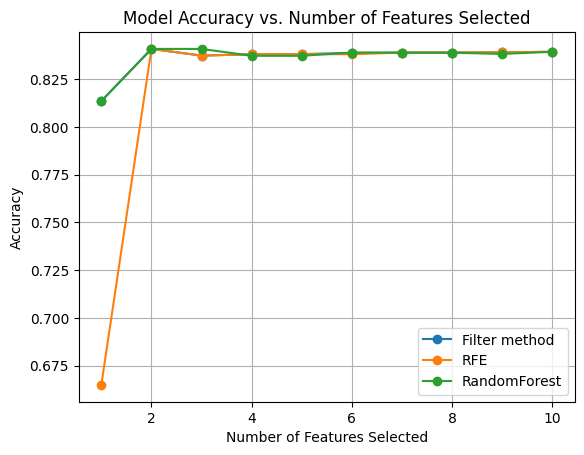

In [19]:
# Plot accuracy vs. number of features
plt.plot(np.arange(1, X_complex.shape[1] + 1), accuracies_filter_complex, marker='o')
plt.plot(np.arange(1, X_complex.shape[1] + 1), accuracies_rfe_complex, marker='o')
plt.plot(np.arange(1, X_complex.shape[1] + 1), accuracies_randf_complex, marker='o')
plt.legend(["Filter method", "RFE", "RandomForest"])
plt.xlabel("Number of Features Selected")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs. Number of Features Selected")
plt.grid()
plt.show()

#### Below the important part is to see that overcrowding increase our accuracy

In [20]:
"""Simulator: ComplexDependentSatisfaction

    Differences in accuracy for different number of important features based on RFE method
    Each time we take the top i feature(s) and check the accuracy of our model
    Our Goal is to show which feature(s) make the model more accurate
"""
for i in [1, 2, 3, 4, 5]:
    # RFE
    rfe = RFE(model, n_features_to_select=i)
    rfe.fit(X_complex_minmax, y_complex)
    
    feature_ranking_complex = pd.DataFrame({
        'feature': X_complex.columns,
        'rank': rfe.ranking_
    }).sort_values(by='rank')
    
    # top i from RFE
    rfe_selected_features_complex = feature_ranking_complex[feature_ranking_complex['rank'] == 1]['feature']
    X_complex_selected = X_complex[rfe_selected_features_complex]

    scale = MinMaxScaler()
    X_complex_selected_minmax = scale.fit_transform(X_complex_selected)

    rfe_log_reg_scores_complex = cross_val_score(
        log_reg, X_complex_selected_minmax, y_complex, scoring='accuracy', cv=cv, n_jobs=-1)
    
    print(f"Selected feature(s) :\n{rfe_selected_features_complex}")
    print(f"Accuracy for {i} feature selected {np.mean(rfe_log_reg_scores_complex)}")

Selected feature(s) :
6    Punctuality
Name: feature, dtype: object
Accuracy for 1 feature selected 0.6649
Selected feature(s) :
6     Punctuality
9    Overcrowding
Name: feature, dtype: object
Accuracy for 2 feature selected 0.8408
Selected feature(s) :
5           Price
6     Punctuality
9    Overcrowding
Name: feature, dtype: object
Accuracy for 3 feature selected 0.8372999999999999
Selected feature(s) :
5           Price
6     Punctuality
7        Duration
9    Overcrowding
Name: feature, dtype: object
Accuracy for 4 feature selected 0.8379999999999999
Selected feature(s) :
2          Income
5           Price
6     Punctuality
7        Duration
9    Overcrowding
Name: feature, dtype: object
Accuracy for 5 feature selected 0.8381000000000001


In [21]:
# find the optimal number of features selected for impact simulation using filter RFE and RandomForest methods
accuracies_filter_impact = np.zeros(X_impact.shape[1])
correlations_selection_impact = corr_results_impact[3]

accuracies_rfe_impact = np.zeros(X_impact.shape[1])

accuracies_randf_impact = np.zeros(X_impact.shape[1])
importances_impact = random_forest_results_impact[3]

for i in range (1, X_impact.shape[1] + 1):
    model = LogisticRegression(max_iter=200, random_state=42)

    # filter method
    corr_impact_selected_features = correlations_selection_impact[1:].index[:i]
    X_impact_selected = X_impact[corr_impact_selected_features]

    scale = MinMaxScaler()
    X_impact_selected_minmax = scale.fit_transform(X_impact_selected)

    corr_log_reg_scores_impact = cross_val_score(
        log_reg, X_impact_selected_minmax, y_impact, scoring='accuracy', cv=cv, n_jobs=-1)

    accuracies_filter_impact[i - 1] = np.mean(corr_log_reg_scores_impact)
    
    # RFE
    rfe = RFE(model, n_features_to_select=i)
    rfe.fit(X_impact_minmax, y_impact)
    
    feature_ranking_impact = pd.DataFrame({
        'feature': X_impact.columns,
        'rank': rfe.ranking_
    }).sort_values(by='rank')
    
    # top i from RFE
    rfe_selected_features_impact = feature_ranking_impact[feature_ranking_impact['rank'] == 1]['feature']
    X_impact_selected = X_impact[rfe_selected_features_impact]

    scale = MinMaxScaler()
    X_impact_selected_minmax = scale.fit_transform(X_impact_selected)

    rfe_log_reg_scores_impact = cross_val_score(
        log_reg, X_impact_selected_minmax, y_impact, scoring='accuracy', cv=cv, n_jobs=-1)

    accuracies_rfe_impact[i - 1] = np.mean(rfe_log_reg_scores_impact)
    
    # Random Forest
    randf_selected_features_impact = importances_impact['feature'][:i]

    X_impact_selected = X_impact[randf_selected_features_impact]

    X_impact_selected_minmax = scale.fit_transform(X_impact_selected)

    randf_log_reg_scores_impact = cross_val_score(
        log_reg, X_impact_selected_minmax, y_impact, scoring='accuracy', cv=cv, n_jobs=-1)
    
    accuracies_randf_impact[i - 1] = np.mean(randf_log_reg_scores_impact)
    

In [22]:
filter_method = np.argmax(accuracies_filter_impact)
rfe_method = np.argmax(accuracies_rfe_impact)
randf_method = np.argmax(accuracies_randf_impact)


print(f"Simulator: {sim_impact}, size = {10_000}")
print(f"Method: Filter, Max accuracy is {accuracies_filter_impact[filter_method]:.6f}, with {filter_method + 1} features selected !")
print(f"Method: RFE, Max accuracy is {accuracies_rfe_impact[rfe_method]:.6f}, with {rfe_method + 1} features selected !")
print(f"Method: Random Forest, Max accuracy is {accuracies_randf_impact[randf_method]:.6f}, with {randf_method + 1} features selected !")

Simulator: ImpactOnOvercrowding, size = 10000
Method: Filter, Max accuracy is 0.851200, with 11 features selected !
Method: RFE, Max accuracy is 0.851500, with 4 features selected !
Method: Random Forest, Max accuracy is 0.851200, with 11 features selected !


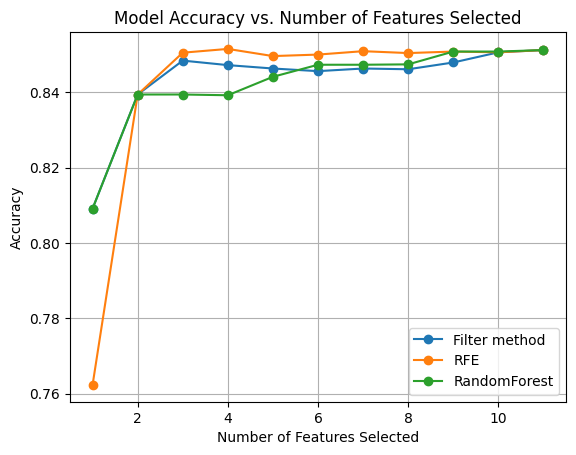

In [23]:
# Plot accuracy vs. number of features
plt.plot(np.arange(1, X_impact.shape[1] + 1), accuracies_filter_impact, marker='o')
plt.plot(np.arange(1, X_impact.shape[1] + 1), accuracies_rfe_impact, marker='o')
plt.plot(np.arange(1, X_impact.shape[1] + 1), accuracies_randf_impact, marker='o')
plt.legend(["Filter method", "RFE", "RandomForest"])
plt.xlabel("Number of Features Selected")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs. Number of Features Selected")
plt.grid()
plt.show()

In [24]:
"""Simulator: ImpactOnOvercrowding

    Differences in accuracy for different number of important features based on RFE method
    Each time we take the top i feature(s) and check the accuracy of our model
    Our Goal is to show which feature(s) make the model more accurate
"""
for i in [1, 2, 3, 4]:
    # RFE
    rfe = RFE(model, n_features_to_select=i)
    rfe.fit(X_impact_minmax, y_impact)
    
    feature_ranking_impact = pd.DataFrame({
        'feature': X_impact.columns,
        'rank': rfe.ranking_
    }).sort_values(by='rank')
    
    # top i from RFE
    rfe_selected_features_impact = feature_ranking_impact[feature_ranking_impact['rank'] == 1]['feature']
    X_impact_selected = X_impact[rfe_selected_features_impact]

    scale = MinMaxScaler()
    X_impact_selected_minmax = scale.fit_transform(X_impact_selected)

    rfe_log_reg_scores_impact = cross_val_score(
        log_reg, X_impact_selected_minmax, y_impact, scoring='accuracy', cv=cv, n_jobs=-1)
    
    print(f"Selected feature(s) :\n{rfe_selected_features_impact}")
    print(f"Accuracy for {i} feature selected {np.mean(rfe_log_reg_scores_impact)}")

Selected feature(s) :
7    Punctuality
Name: feature, dtype: object
Accuracy for 1 feature selected 0.7623
Selected feature(s) :
7      Punctuality
10    Overcrowding
Name: feature, dtype: object
Accuracy for 2 feature selected 0.8394
Selected feature(s) :
6            Price
7      Punctuality
10    Overcrowding
Name: feature, dtype: object
Accuracy for 3 feature selected 0.8504999999999999
Selected feature(s) :
5      First-Class
6            Price
7      Punctuality
10    Overcrowding
Name: feature, dtype: object
Accuracy for 4 feature selected 0.8515


In [25]:
# Data Generation
sim_complex, sim_impact = generate_data(10000)

data_complex = sim_complex.df
data_complex['Gender'] = data_complex['Gender'].map({'M': 1, 'F': 0})
data_complex['Has Car'] = data_complex['Has Car'].map({'yes': 1, 'no': 0})

data_impact = sim_impact.df
data_impact['Gender'] = data_impact['Gender'].map({'M': 1, 'F': 0})
data_impact['Has Car'] = data_impact['Has Car'].map({'yes': 1, 'no': 0})

X_complex = data_complex.drop(columns=['Satisfaction'])
y_complex = data_complex['Satisfaction']

X_impact = data_impact.drop(columns=['Satisfaction'])
y_impact = data_impact['Satisfaction']


### ImpactOnOvercrowding Difference between First-Class and Regulars

In [26]:
sim_impact = ImpactOnOvercrowding(10000)
sim_complex = ComplexDependentSatisfaction(10000)

data_impact = sim_impact.df
data_complex = sim_complex.df
first_class = data_impact[data_impact["First-Class"]== '1']
first_class.head()

,Age,Gender,Income,Remote Working Days,Has Car,First-Class,Price,Punctuality,Duration,Frequency,Overcrowding,Satisfaction
6,90,F,84000,3,no,1,3,5,3,1,1,1
7,60,M,109000,5,no,1,4,5,2,1,1,1
8,90,M,84000,2,no,1,5,4,4,3,1,1
9,15,M,1000,3,no,1,4,2,4,1,1,1
11,15,M,1000,1,no,1,3,5,3,4,1,1


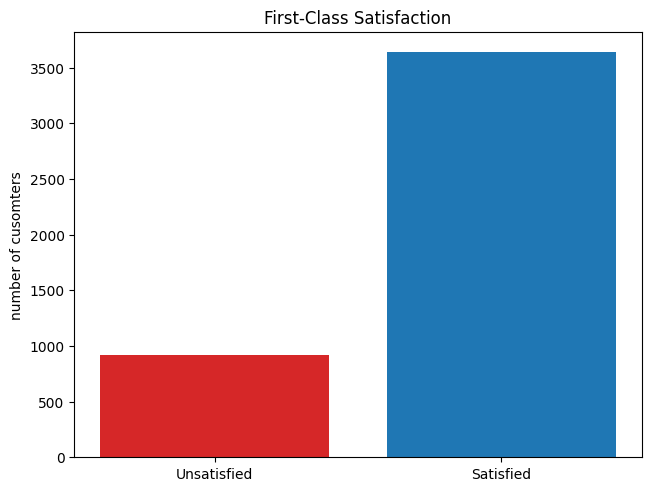

Probability of satisfaction given that you are in First-Class: 0.798771


In [27]:
satisf_first_class = first_class['Satisfaction'].value_counts()

fig, ax = plt.subplots(layout="constrained")
bar_colors = ['tab:red', 'tab:blue']
ax.bar(["Unsatisfied", "Satisfied"], 
       [satisf_first_class['0'], satisf_first_class['1']], color=bar_colors)
ax.set_ylabel("number of cusomters")
ax.set_title(f"First-Class Satisfaction")
plt.show()
prob_satisf_first_class = satisf_first_class['1'] / (satisf_first_class['0'] + satisf_first_class['1'])
print(f"Probability of satisfaction given that you are in First-Class: {prob_satisf_first_class:.6f}")

In [28]:
regulars = data_impact[data_impact["First-Class"]== '0']
regulars.head()

,Age,Gender,Income,Remote Working Days,Has Car,First-Class,Price,Punctuality,Duration,Frequency,Overcrowding,Satisfaction
0,15,M,1000,1,no,0,3,5,5,2,2,1
1,26,F,60680,4,no,0,1,4,2,1,2,1
2,40,M,84000,4,no,0,3,5,2,3,5,0
3,40,F,164000,1,yes,0,5,2,4,0,5,0
4,60,M,84000,4,no,0,4,5,5,0,3,1


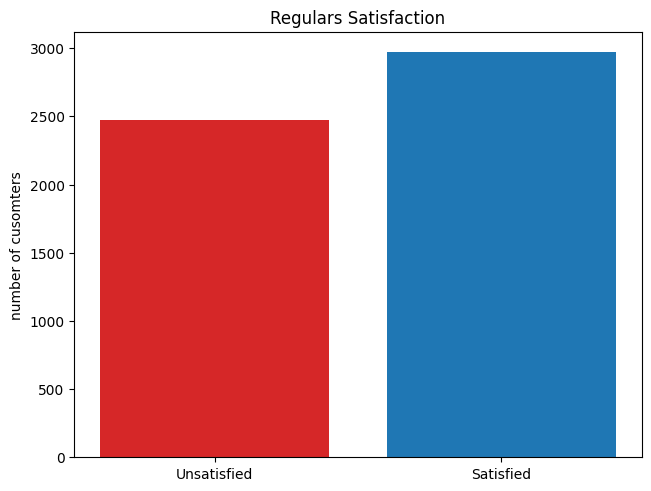

In [29]:
satisf_regulars = regulars['Satisfaction'].value_counts()

fig, ax = plt.subplots(layout="constrained")
bar_colors = ['tab:red', 'tab:blue']
ax.bar(["Unsatisfied", "Satisfied"], 
       [satisf_regulars['0'], satisf_regulars['1']], color=bar_colors)
ax.set_ylabel("number of cusomters")
ax.set_title(f"Regulars Satisfaction")
plt.show()

#### Probabilities

In [30]:
prob_satisf_first_class = satisf_first_class['1'] / (satisf_first_class['0'] + satisf_first_class['1'])
prob_satisf_regulars = satisf_regulars['1'] / (satisf_regulars['0'] + satisf_regulars['1'])

size_of_data = satisf_first_class['1'] + satisf_regulars['1'] + satisf_first_class['0'] + satisf_regulars['0']
total_satisfaction = satisf_first_class['1'] + satisf_regulars['1']

print(f"Probabilty of being on first class given that you are satisfied: {satisf_first_class['1'] / total_satisfaction:.6f}")
print(f"Probabilty of being in second class given that you are satisfied: {satisf_regulars['1'] / total_satisfaction:.6f}")
print(f"Probability of satisfaction given that you are in first class: {prob_satisf_first_class:.6f}")
print(f"Probability of satisfaction given that you are in second class: {prob_satisf_regulars:.6f}")

Probabilty of being on first class given that you are satisfied: 0.550514
Probabilty of being in second class given that you are satisfied: 0.449486
Probability of satisfaction given that you are in first class: 0.798771
Probability of satisfaction given that you are in second class: 0.546022


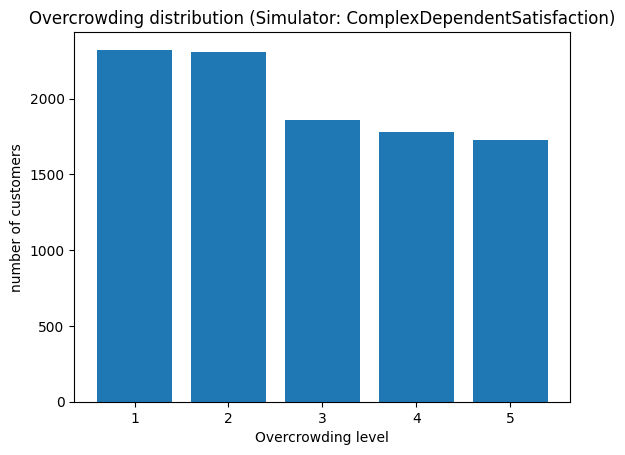

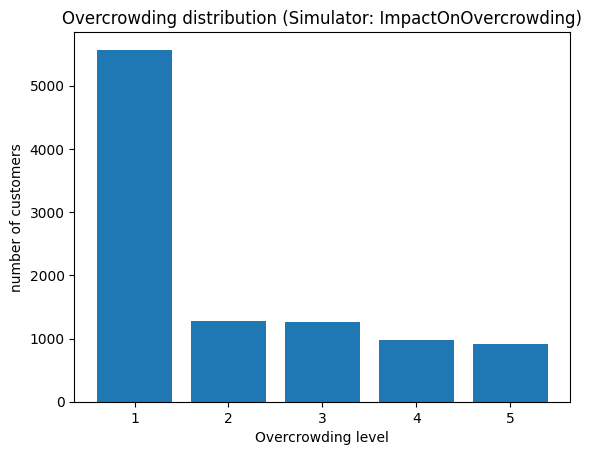

Overcrowding
1    4557
Name: count, dtype: int64


In [31]:
overcrowding = data_complex['Overcrowding'].value_counts()
plt.bar([1, 2, 3, 4, 5], overcrowding)
plt.xlabel("Overcrowding level")
plt.ylabel("number of customers")
plt.title("Overcrowding distribution (Simulator: ComplexDependentSatisfaction)")

plt.show()
overcrowding = data_impact['Overcrowding'].value_counts()
plt.bar([1, 2, 3, 4, 5], overcrowding)
plt.xlabel("Overcrowding level")
plt.ylabel("number of customers")
plt.title("Overcrowding distribution (Simulator: ImpactOnOvercrowding)")

plt.show()
overcrowding = data_impact[data_impact['First-Class'] == '1']['Overcrowding'].value_counts()
print(overcrowding)